## **Distribution Checks: County, Block Group, Solar-Containing Block Group, and Project**
### Technoeconomic + Social Factors

This notebook performs distribution sanity-checks with KDE plots using consistent color coding across figures:
- **County** = red  
- **Block Group (all)** = green  
- **Block Group (Solar Only)** = purple  
- **Project** = blue  

### What is included
**Technoeconomic suitability variables (0–100):**
- GHI
- Protected Land
- Habitat
- Slope
- Population Density
- Distance to Substation
- Land Cover
For technoeconomic factors, the notebook includes:
1. A full comparison on the same axis: **County vs BG (all) vs Solar-BG vs Project**
2. A cleaner comparison: **County vs Solar-BG vs Project**

**Social variables:**
- Income (USD)
- HS education only (% of population age 25+, 0–100)
- Graduate/Professional degree only (% of population age 25+, 0–100)
- Black and Asian population shares (% of population, 0–100)
- Unemployment rate (%)

For social factors, the notebook compares:
- **County vs BG (all) vs Solar-BG**

> Note: Project-level social curves are intentionally excluded, since social/demographic attributes are not directly observed at project footprint level.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

In [42]:
basepath = basepath

# Suitability tables
suitability_county = pd.read_csv(basepath + "suitability_scores/suitability_scores_county.csv")
suitability_bg = pd.read_csv(basepath + "suitability_scores/suitability_scores_bg.csv")
project_suitability = pd.read_csv(basepath + "suitability_scores/suitability_scores_project.csv")

# Social factor source tables
bg_income = pd.read_csv(basepath + "block_group_clean/income_bg.csv")
bg_edu    = pd.read_csv(basepath + "block_group_clean/education_bg.csv")
bg_unemp  = pd.read_csv(basepath + "block_group_clean/unemployment_bg.csv")

try:
    bg_race = pd.read_csv(basepath + "block_group_clean/race_percent_bg.csv")
    race_source = "race_percent_bg.csv"
except FileNotFoundError:
    bg_race = pd.read_csv(basepath + "block_group_clean/race_bg.csv")
    race_source = "race_bg.csv"

cty_social = pd.read_csv(basepath + "county_clean/social_factors_merged.csv")

print("Using BG race file:", race_source)
print("Loaded datasets.")

Using BG race file: race_percent_bg.csv
Loaded datasets.


In [43]:
def pad_str(series, width):
    return (
        series.astype(str)
        .str.replace(r"\.0$", "", regex=True)
        .str.strip()
        .str.zfill(width)
    )

def ensure_geoid_bg(df, name):
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]

    if "GEOID" in df.columns:
        df["GEOID"] = (
            df["GEOID"].astype(str)
            .str.replace(r"\.0$", "", regex=True)
            .str.strip()
            .str.zfill(12)
            .str[:12]
        )
        return df

    def has_cols(cols):
        return all(c in df.columns for c in cols)

    if has_cols(["State", "County", "Tract", "Block"]):
        df["GEOID"] = (
            pad_str(df["State"], 2)
            + pad_str(df["County"], 3)
            + pad_str(df["Tract"], 6)
            + pad_str(df["Block"], 1)
        )
        return df

    if has_cols(["State", "County", "Tract", "Block Group"]):
        df["GEOID"] = (
            pad_str(df["State"], 2)
            + pad_str(df["County"], 3)
            + pad_str(df["Tract"], 6)
            + pad_str(df["Block Group"], 1)
        )
        return df

    if has_cols(["STATEFP", "COUNTYFP", "TRACTCE", "BLKGRPCE"]):
        df["GEOID"] = (
            pad_str(df["STATEFP"], 2)
            + pad_str(df["COUNTYFP"], 3)
            + pad_str(df["TRACTCE"], 6)
            + pad_str(df["BLKGRPCE"], 1)
        )
        return df

    raise KeyError(f"[{name}] Could not construct BG GEOID. Columns: {list(df.columns)}")

def ensure_geoid_county(df, name):
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]

    if "GEOID" in df.columns:
        df["GEOID"] = (
            df["GEOID"].astype(str)
            .str.replace("US", "", regex=False)
            .str.replace(r"\.0$", "", regex=True)
            .str.strip()
            .str.zfill(5)
            .str[:5]
        )
        return df

    for c in ["FIPS", "fips", "CountyFIPS", "COUNTY_FIPS", "county_fips", "GEOIDFQ"]:
        if c in df.columns:
            df["GEOID"] = (
                df[c].astype(str)
                .str.replace("US", "", regex=False)
                .str.replace(r"\.0$", "", regex=True)
                .str.strip()
                .str.zfill(5)
                .str[:5]
            )
            return df

    state_candidates = ["STATEFP", "statefp", "State", "STATE", "FIPS State"]
    county_candidates = ["COUNTYFP", "countyfp", "County", "COUNTY", "FIPS County"]

    state_col = next((c for c in state_candidates if c in df.columns), None)
    county_col = next((c for c in county_candidates if c in df.columns), None)

    if state_col is not None and county_col is not None:
        df["GEOID"] = pad_str(df[state_col], 2) + pad_str(df[county_col], 3)
        return df

    if "County Name" in df.columns and "State" in df.columns:
        return df

    raise KeyError(f"[{name}] Could not construct county GEOID. Columns: {list(df.columns)}")

In [44]:
suitability_bg = ensure_geoid_bg(suitability_bg, "suitability_bg")
project_suitability = ensure_geoid_bg(project_suitability, "project_suitability")
bg_income = ensure_geoid_bg(bg_income, "bg_income")
bg_edu = ensure_geoid_bg(bg_edu, "bg_edu")
bg_race = ensure_geoid_bg(bg_race, "bg_race")
bg_unemp = ensure_geoid_bg(bg_unemp, "bg_unemp")

cty_social = ensure_geoid_county(cty_social, "cty_social")

suitability_county = ensure_geoid_county(suitability_county, "suitability_county")

# If still missing GEOID, map with County Name + State
if "GEOID" not in suitability_county.columns:
    print("suitability_county has no GEOID; attempting County Name + State mapping...")

    county_name_col = next((c for c in cty_social.columns if c.lower().strip() in ["county name", "county", "name"]), None)
    state_name_col = next((c for c in cty_social.columns if c.lower().strip() in ["state", "state name"]), None)

    if county_name_col is None or state_name_col is None:
        raise KeyError("Could not find county/state name columns in cty_social for mapping.")

    lookup = (
        cty_social[[county_name_col, state_name_col, "GEOID"]]
        .dropna()
        .drop_duplicates()
        .rename(columns={county_name_col: "County Name", state_name_col: "State"})
    )

    for col in ["County Name", "State"]:
        suitability_county[col] = suitability_county[col].astype(str).str.strip().str.lower()
        lookup[col] = lookup[col].astype(str).str.strip().str.lower()

    suitability_county = suitability_county.merge(lookup, on=["County Name", "State"], how="left")

missing_rate = suitability_county["GEOID"].isna().mean() * 100 if "GEOID" in suitability_county.columns else 100
print(f"suitability_county GEOID missing rate: {missing_rate:.2f}%")

print("BG GEOID example:", suitability_bg["GEOID"].head(1).tolist())
print("Project GEOID example:", project_suitability["GEOID"].head(1).tolist())
print("County social GEOID example:", cty_social["GEOID"].head(1).tolist())

suitability_county has no GEOID; attempting County Name + State mapping...
suitability_county GEOID missing rate: 4.10%
BG GEOID example: ['011130303001']
Project GEOID example: ['250092072001']
County social GEOID example: ['01001']


In [45]:
# BGs that contain at least one project
solar_bg_geoids = set(project_suitability["GEOID"].dropna().astype(str).unique())
print("Solar BG count:", len(solar_bg_geoids))

# Tech tables
suitability_bg_all = suitability_bg.copy()
suitability_bg_solar = suitability_bg[suitability_bg["GEOID"].isin(solar_bg_geoids)].copy()

print("suitability_bg_all rows:", len(suitability_bg_all))
print("suitability_bg_solar rows:", len(suitability_bg_solar))
print("project_suitability rows:", len(project_suitability))

Solar BG count: 2963
suitability_bg_all rows: 237804
suitability_bg_solar rows: 2963
project_suitability rows: 4140


In [46]:
# Fixed social columns 
cty_income_col = "Median Income"
cty_hs_col     = "25+ High school graduate"
cty_grad_col   = "25+ Graduate or professional degree"
cty_black_col  = "Black/African American"
cty_asian_col  = "Asian"
cty_unemp_col  = "Unemployment Rate"

bg_income_col = "Median Household Income"
bg_hs_col     = "high_school_graduate"
bg_grad_col   = "graduate_degree"
bg_black_col  = "African American Only Percentage"
bg_asian_col  = "Asian Only Percentage"
bg_unemp_col  = "Unemployment Rate"

checks = [
    ("cty_income", cty_social, cty_income_col),
    ("cty_hs", cty_social, cty_hs_col),
    ("cty_grad", cty_social, cty_grad_col),
    ("cty_black", cty_social, cty_black_col),
    ("cty_asian", cty_social, cty_asian_col),
    ("cty_unemp", cty_social, cty_unemp_col),
    ("bg_income", bg_income, bg_income_col),
    ("bg_hs", bg_edu, bg_hs_col),
    ("bg_grad", bg_edu, bg_grad_col),
    ("bg_black", bg_race, bg_black_col),
    ("bg_asian", bg_race, bg_asian_col),
    ("bg_unemp", bg_unemp, bg_unemp_col),
]
for name, df, col in checks:
    if col not in df.columns:
        raise KeyError(f"[MISSING] {name}: {col}")

print("All required social columns found.")

# County social
cty_social_small = cty_social[[
    "GEOID", cty_income_col, cty_hs_col, cty_grad_col, cty_black_col, cty_asian_col, cty_unemp_col
]].copy().rename(columns={
    cty_income_col: "Income",
    cty_hs_col: "HS_Education",
    cty_grad_col: "Grad_Education",
    cty_black_col: "Black",
    cty_asian_col: "Asian",
    cty_unemp_col: "Unemployment"
})

# BG social all
bg_social_all = (
    bg_income[["GEOID", bg_income_col]].copy()
    .merge(bg_edu[["GEOID", bg_hs_col, bg_grad_col]], on="GEOID", how="left")
    .merge(bg_race[["GEOID", bg_black_col, bg_asian_col]], on="GEOID", how="left")
    .merge(bg_unemp[["GEOID", bg_unemp_col]], on="GEOID", how="left")
    .rename(columns={
        bg_income_col: "Income",
        bg_hs_col: "HS_Education",
        bg_grad_col: "Grad_Education",
        bg_black_col: "Black",
        bg_asian_col: "Asian",
        bg_unemp_col: "Unemployment"
    })
)

# BG social solar-only
bg_social_solar = bg_social_all[bg_social_all["GEOID"].isin(solar_bg_geoids)].copy()

print("cty_social_small rows:", len(cty_social_small))
print("bg_social_all rows:", len(bg_social_all))
print("bg_social_solar rows:", len(bg_social_solar))

All required social columns found.
cty_social_small rows: 3125
bg_social_all rows: 242336
bg_social_solar rows: 2963


In [47]:
def to_percent_mixed_units(series):
    """
    Convert mixed-unit percentage columns to 0–100 scale.
    Values <= 1.5 are treated as fractions and multiplied by 100.
    """
    s = pd.to_numeric(series, errors="coerce")
    return s.where(~(s <= 1.5), s * 100)

# Convert percent-like columns to 0-100 for BOTH county and BG tables
pct_cols = ["HS_Education", "Grad_Education", "Black", "Asian", "Unemployment"]

for col in pct_cols:
    if col in cty_social_small.columns:
        cty_social_small[col] = to_percent_mixed_units(cty_social_small[col])
    if col in bg_social_all.columns:
        bg_social_all[col] = to_percent_mixed_units(bg_social_all[col])
    if col in bg_social_solar.columns:
        bg_social_solar[col] = to_percent_mixed_units(bg_social_solar[col])

# Keep valid ranges
for df_name, df in [("cty_social_small", cty_social_small), ("bg_social_all", bg_social_all), ("bg_social_solar", bg_social_solar)]:
    for c in pct_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
            df.loc[(df[c] < 0) | (df[c] > 100), c] = pd.NA

# Income nonnegative
for df in [cty_social_small, bg_social_all, bg_social_solar]:
    if "Income" in df.columns:
        df["Income"] = pd.to_numeric(df["Income"], errors="coerce")
        df.loc[df["Income"] < 0, "Income"] = pd.NA

print("Unit harmonization and cleaning complete.")

Unit harmonization and cleaning complete.


In [48]:
print("TECHNOECONOMIC TABLES")
display(suitability_county.describe(include="all"))
display(suitability_bg_all.describe(include="all"))
display(suitability_bg_solar.describe(include="all"))
display(project_suitability.describe(include="all"))

print("SOCIAL TABLES")
display(cty_social_small.describe(include="all"))
display(bg_social_all.describe(include="all"))
display(bg_social_solar.describe(include="all"))

TECHNOECONOMIC TABLES


,GHI,Protected_Land,Habitat,Slope,Population_Density,Distance_to_Substation,Land_Cover,County Name,State,GEOID
count,3115.000000,3115.000000,3115.000000,3115.000000,3115.000000,3115.000000,3115.000000,3240,3240,3107
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1812,50,3101
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,texas,00nan
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133,254,7
mean,18.076721,89.879833,57.455781,69.702828,88.435246,57.119300,71.184278,NaN,NaN,NaN
std,16.819495,13.816030,20.158487,30.011318,19.358717,9.255557,13.513193,NaN,NaN,NaN
min,4.765299,2.379858,15.361651,0.138137,10.000000,50.000000,27.518503,NaN,NaN,NaN
25%,5.649519,87.433210,39.890309,48.552751,87.952776,50.000000,59.783021,NaN,NaN,NaN
50%,15.000000,95.797324,55.633626,80.660613,96.903676,53.250672,69.315001,NaN,NaN,NaN
75%,20.000000,98.547830,74.609285,95.721146,99.193588,61.065374,83.902544,NaN,NaN,NaN


,GHI,Protected_Land,Habitat,Slope,Population_Density,Distance_to_Substation,Land_Cover,County Name,State,GEOID,TRACTCE,BLKGRPCE
count,237770.000000,237804.000000,237804.000000,237792.000000,237786.000000,237804.000000,237792.000000,237804,237804,237804,237804.000000,237804.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1816,49,237804,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Los Angeles,California,011130303001,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6587,25586,1,NaN,NaN
mean,21.747509,94.708899,73.291660,82.735631,27.238352,73.078445,71.379701,NaN,NaN,NaN,254500.405910,2.125444
std,23.774010,13.040835,26.459468,25.915605,31.641067,17.013869,9.247064,NaN,NaN,NaN,347586.307108,1.109086
min,3.763716,0.000000,5.000000,0.000000,10.000000,50.000000,1.000000,NaN,NaN,NaN,100.000000,0.000000
25%,5.000000,97.500000,47.272727,75.559432,10.000000,50.000000,67.992490,NaN,NaN,NaN,10367.000000,1.000000
50%,15.000000,100.000000,82.842183,96.500000,10.000000,75.000000,75.000000,NaN,NaN,NaN,42601.000000,2.000000
75%,20.000000,100.000000,98.095238,100.000000,23.656716,90.000000,75.000000,NaN,NaN,NaN,452000.000000,3.000000


,GHI,Protected_Land,Habitat,Slope,Population_Density,Distance_to_Substation,Land_Cover,County Name,State,GEOID,TRACTCE,BLKGRPCE
count,2963.000000,2963.000000,2963.000000,2963.000000,2963.000000,2963.000000,2963.000000,2963,2963,2963,2963.000000,2963.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,668,47,2963,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Worcester,North Carolina,240199709001,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84,483,1,NaN,NaN
mean,23.792125,92.852029,58.654094,82.495685,56.572399,68.600659,71.184306,NaN,NaN,NaN,366197.010462,1.985150
std,27.478555,12.428673,23.121386,23.056785,38.597960,16.825482,11.815338,NaN,NaN,NaN,406167.646168,1.078509
min,5.000000,0.000000,7.001278,1.724806,10.000000,50.000000,26.530201,NaN,NaN,NaN,100.000000,1.000000
25%,5.000000,91.408626,39.029409,72.326051,13.361175,50.000000,62.510490,NaN,NaN,NaN,11200.500000,1.000000
50%,15.000000,98.940810,55.024655,94.083333,54.916736,69.852354,70.832381,NaN,NaN,NaN,90301.000000,2.000000
75%,20.000000,100.000000,78.970715,99.492989,99.093769,85.869870,80.015218,NaN,NaN,NaN,850352.000000,3.000000


,GHI,Protected_Land,Habitat,Slope,Population_Density,Distance_to_Substation,Land_Cover,geometry,Wattage,GEOID,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE
count,4140.000000,4140.000000,4140.000000,4140.000000,4140.000000,4140.000000,4140.000000,4140,4140.000000,4140,4140.000000,4140.000000,4140.000000,4140.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4058,NaN,2963,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT Z (-76.22000000000001 39.436000000000064 0),NaN,060379009012,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,23,NaN,NaN,NaN,NaN
mean,26.617995,91.404584,56.852154,81.429263,66.118968,67.712012,71.933863,NaN,13.315990,NaN,26.415942,69.671014,366687.887198,1.944928
std,30.097977,10.942445,18.511924,20.715437,30.324749,13.728775,11.906616,NaN,36.065576,NaN,13.714619,69.921977,407403.489290,1.068724
min,5.000000,26.827272,5.000000,5.533967,10.000000,50.000000,36.011814,NaN,0.300000,NaN,1.000000,1.000000,100.000000,1.000000
25%,5.000000,89.015293,40.333791,69.321071,39.747696,52.757083,62.773331,NaN,1.600000,NaN,13.000000,23.000000,11000.000000,1.000000
50%,15.000000,95.123272,55.067886,89.492648,75.592099,68.682482,69.907433,NaN,3.000000,NaN,27.000000,47.000000,90302.000000,2.000000
75%,20.000000,98.730026,70.816464,98.150696,93.882585,80.210641,83.141726,NaN,5.200000,NaN,37.000000,103.000000,870125.000000,3.000000


SOCIAL TABLES


,GEOID,Income,HS_Education,Grad_Education,Black,Asian,Unemployment
count,3125,3105.000000,3106.000000,3099.000000,3106.000000,3106.000000,3061.000000
unique,3101,NaN,NaN,NaN,NaN,NaN,NaN
top,00nan,NaN,NaN,NaN,NaN,NaN,NaN
freq,25,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,58091.142673,33.941243,8.323266,8.671075,1.334867,6.388762
std,NaN,15488.380263,7.503094,5.653406,14.085064,2.573158,8.992531
min,NaN,17109.000000,6.500000,0.000000,0.000000,0.000000,0.000000
25%,NaN,48101.000000,29.200000,5.150000,0.501750,0.317774,3.800000
50%,NaN,55827.000000,34.200000,6.800000,2.031984,0.542127,5.000000
75%,NaN,64715.000000,39.200000,10.000000,9.893034,1.218718,6.500000


,GEOID,Income,HS_Education,Grad_Education,Black,Asian,Unemployment
count,242336,222600.000000,239383.000000,234536.000000,238235.000000,238235.000000,239770.000000
unique,242336,NaN,NaN,NaN,NaN,NaN,NaN
top,010010201001,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,82166.628050,27.565046,14.559968,12.923637,5.243623,5.633204
std,NaN,42043.886614,14.341043,14.867738,20.723713,9.794008,6.856074
min,NaN,2579.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,52375.000000,16.883117,4.579340,1.092233,0.493883,0.888123
50%,NaN,73244.000000,27.057275,9.961686,3.889304,1.666667,3.676471
75%,NaN,102917.000000,37.142857,19.751527,13.893313,5.192683,7.802655


,GEOID,Income,HS_Education,Grad_Education,Black,Asian,Unemployment
count,2963,2717.000000,2902.000000,2813.000000,2909.000000,2909.000000,2888.000000
unique,2963,NaN,NaN,NaN,NaN,NaN,NaN
top,010159819011,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,81829.216047,30.620744,12.740529,11.314672,3.272081,5.338693
std,NaN,37908.394839,12.502286,14.371589,17.325992,7.044429,6.162550
min,NaN,7292.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,54712.000000,22.329177,4.148784,0.769928,0.351803,1.141773
50%,NaN,74344.000000,30.609885,8.473282,3.030303,0.932836,3.694203
75%,NaN,101855.000000,38.617484,15.932914,14.054998,2.687225,7.422694


In [49]:
def sanity(series, name):
    s = pd.to_numeric(series, errors="coerce")
    print(
        f"{name:30s}",
        f"min={s.min():.3f}",
        f"p50={s.quantile(0.5):.3f}",
        f"p90={s.quantile(0.9):.3f}",
        f"max={s.max():.3f}",
        f"%nan={s.isna().mean()*100:.2f}%"
    )

for col in ["Income", "HS_Education", "Grad_Education", "Black", "Asian", "Unemployment"]:
    sanity(cty_social_small[col], f"County {col}")
    sanity(bg_social_all[col], f"BG-All {col}")
    sanity(bg_social_solar[col], f"BG-Solar {col}")

County Income                  min=17109.000 p50=55827.000 p90=76332.200 max=156821.000 %nan=0.64%
BG-All Income                  min=2579.000 p50=73244.000 p90=140208.000 max=250000.000 %nan=8.14%
BG-Solar Income                min=7292.000 p50=74344.000 p90=131852.800 max=245347.000 %nan=8.30%
County HS_Education            min=6.500 p50=34.200 p90=43.400 max=53.400 %nan=0.61%
BG-All HS_Education            min=0.000 p50=27.057 p90=46.238 max=100.000 %nan=1.22%
BG-Solar HS_Education          min=0.000 p50=30.610 p90=46.395 max=100.000 %nan=2.06%
County Grad_Education          min=0.000 p50=6.800 p90=14.120 max=90.000 %nan=0.83%
BG-All Grad_Education          min=0.000 p50=9.962 p90=32.898 max=100.000 %nan=3.22%
BG-Solar Grad_Education        min=0.000 p50=8.473 p90=27.325 max=100.000 %nan=5.06%
County Black                   min=0.000 p50=2.032 p90=28.772 max=87.126 %nan=0.61%
BG-All Black                   min=0.000 p50=3.889 p90=40.446 max=100.000 %nan=1.69%
BG-Solar Black         

In [50]:
# Consistent color mapping for all plots
COLORS = {
    "County": "red",
    "Block Group": "green",
    "Block Group (Solar Only)": "purple",
    "Project": "blue",
}

def safe_numeric(df, col):
    if df is None or col not in df.columns:
        return None
    s = pd.to_numeric(df[col], errors="coerce").dropna()
    if len(s) < 10 or s.nunique() < 2:
        return None
    return s

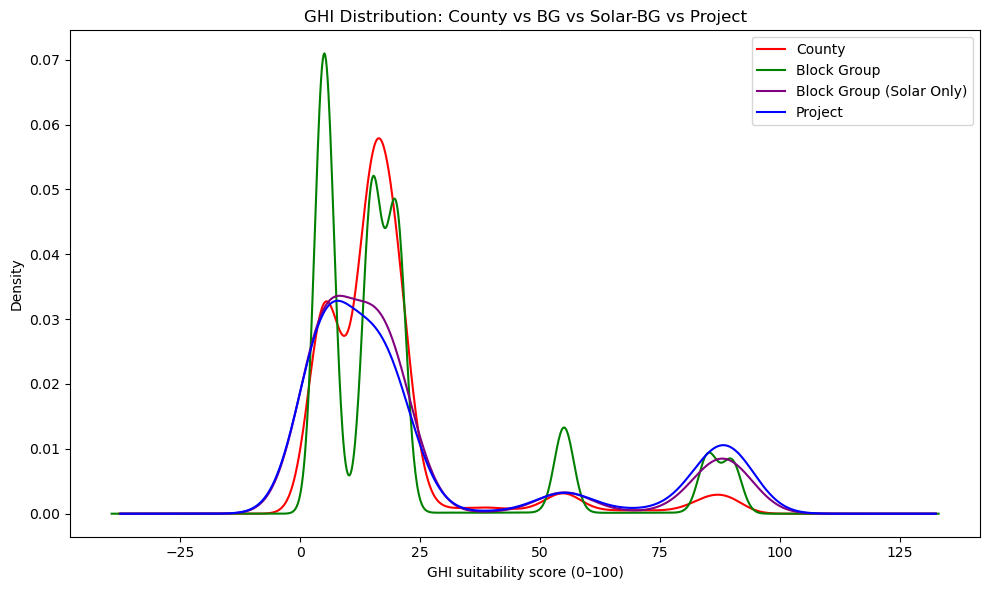

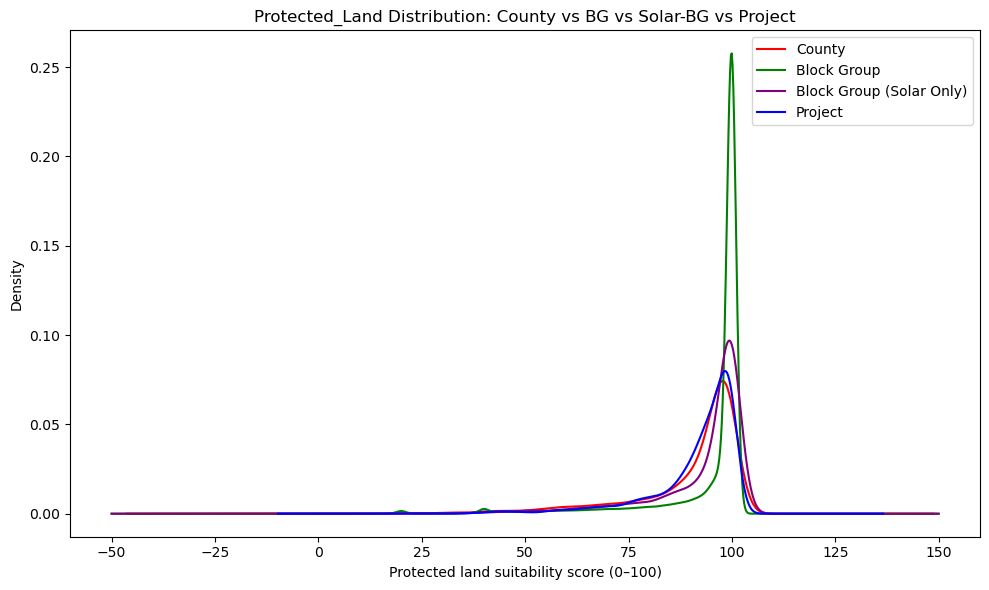

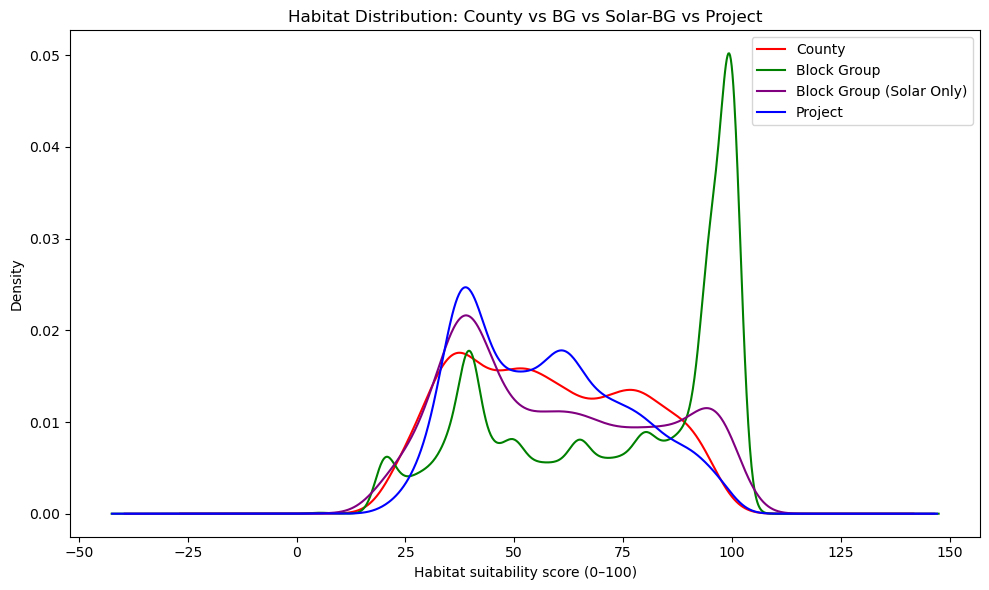

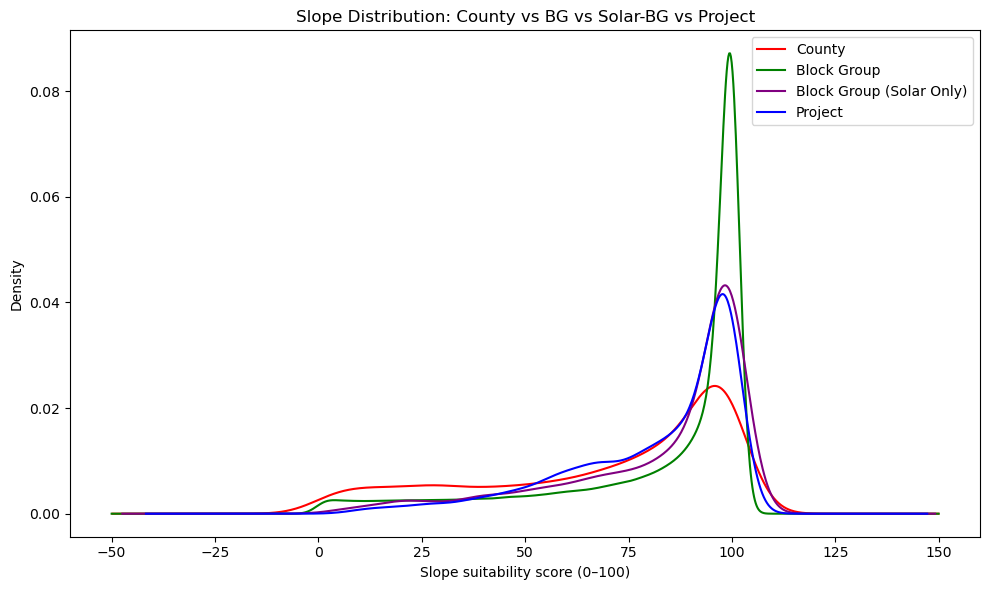

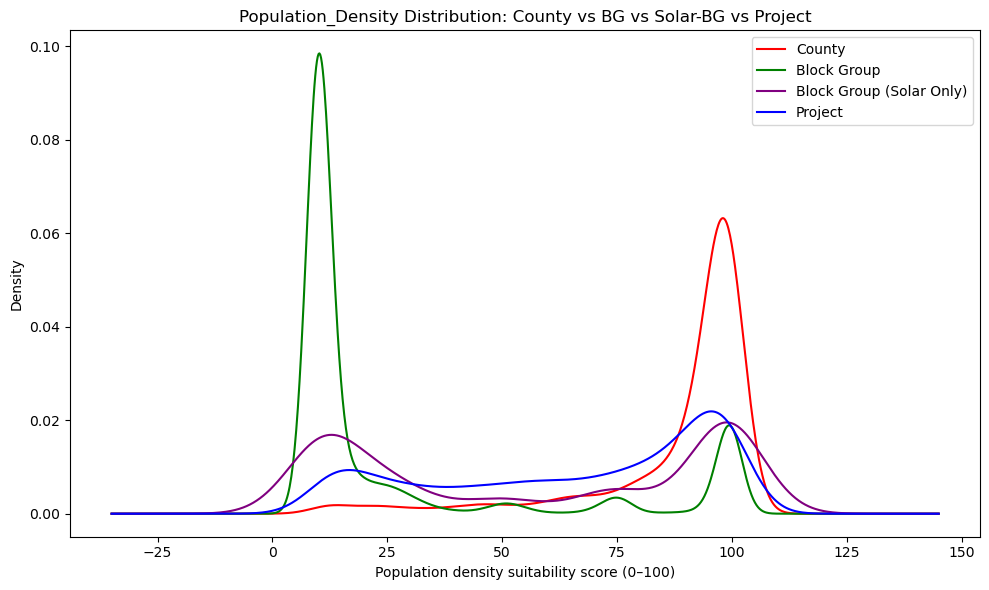

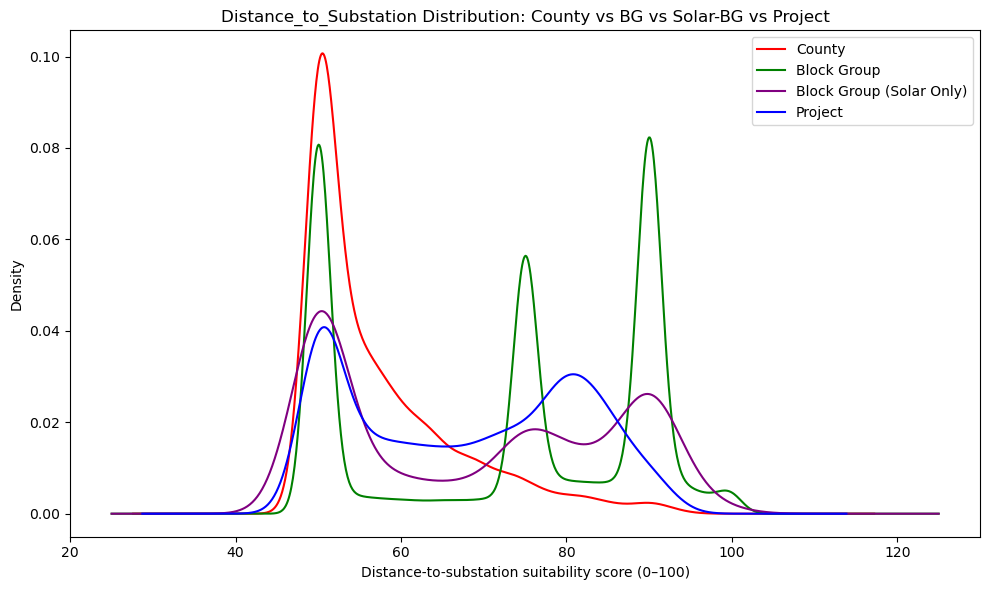

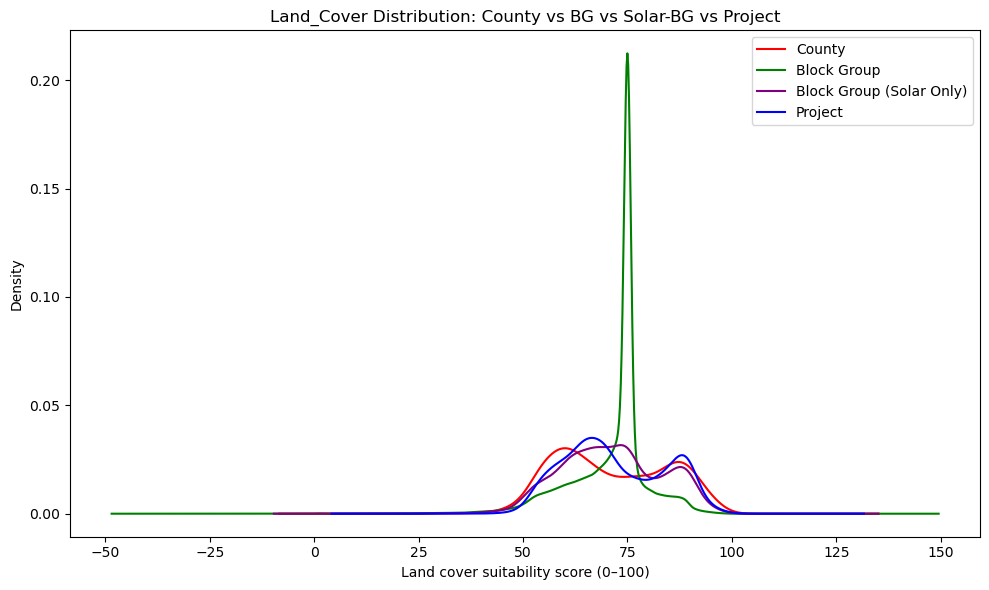

In [51]:
tech_factors = [
    "GHI", "Protected_Land", "Habitat", "Slope",
    "Population_Density", "Distance_to_Substation", "Land_Cover"
]

tech_xlabels = {
    "GHI": "GHI suitability score (0–100)",
    "Protected_Land": "Protected land suitability score (0–100)",
    "Habitat": "Habitat suitability score (0–100)",
    "Slope": "Slope suitability score (0–100)",
    "Population_Density": "Population density suitability score (0–100)",
    "Distance_to_Substation": "Distance-to-substation suitability score (0–100)",
    "Land_Cover": "Land cover suitability score (0–100)",
}

for factor in tech_factors:
    c = safe_numeric(suitability_county, factor)
    b_all = safe_numeric(suitability_bg_all, factor)
    b_sol = safe_numeric(suitability_bg_solar, factor)
    p = safe_numeric(project_suitability, factor)

    fig, ax = plt.subplots(figsize=(10, 6))

    if c is not None:
        c.plot(kind="kde", ax=ax, color=COLORS["County"], label="County")
    if b_all is not None:
        b_all.plot(kind="kde", ax=ax, color=COLORS["Block Group"], label="Block Group")
    if b_sol is not None:
        b_sol.plot(kind="kde", ax=ax, color=COLORS["Block Group (Solar Only)"], label="Block Group (Solar Only)")
    if p is not None:
        p.plot(kind="kde", ax=ax, color=COLORS["Project"], label="Project")

    ax.set_title(f"{factor} Distribution: County vs BG vs Solar-BG vs Project")
    ax.set_xlabel(tech_xlabels.get(factor, f"{factor} suitability score"))
    ax.set_ylabel("Density")

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend()

    plt.tight_layout()
    plt.show()

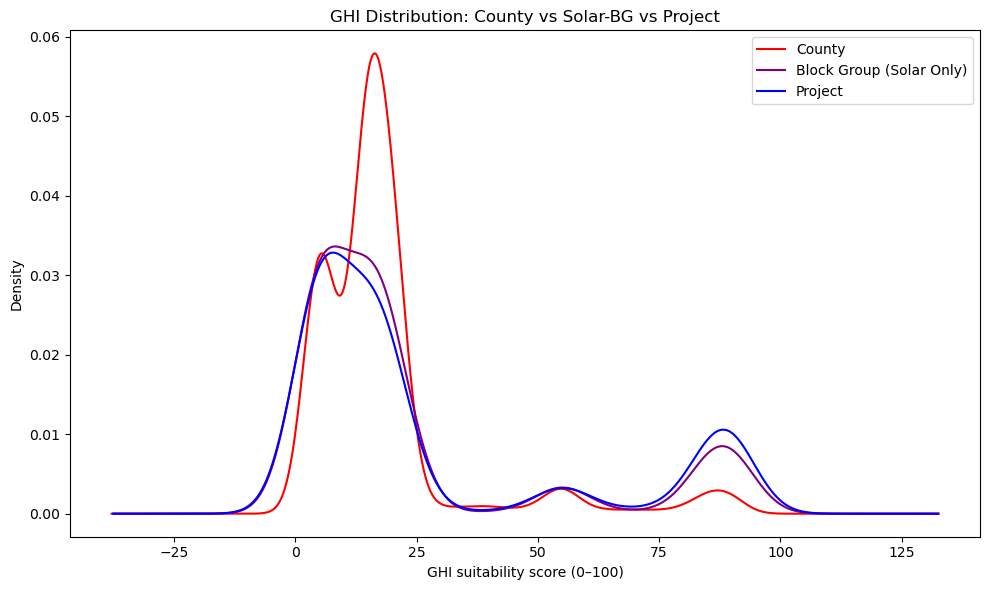

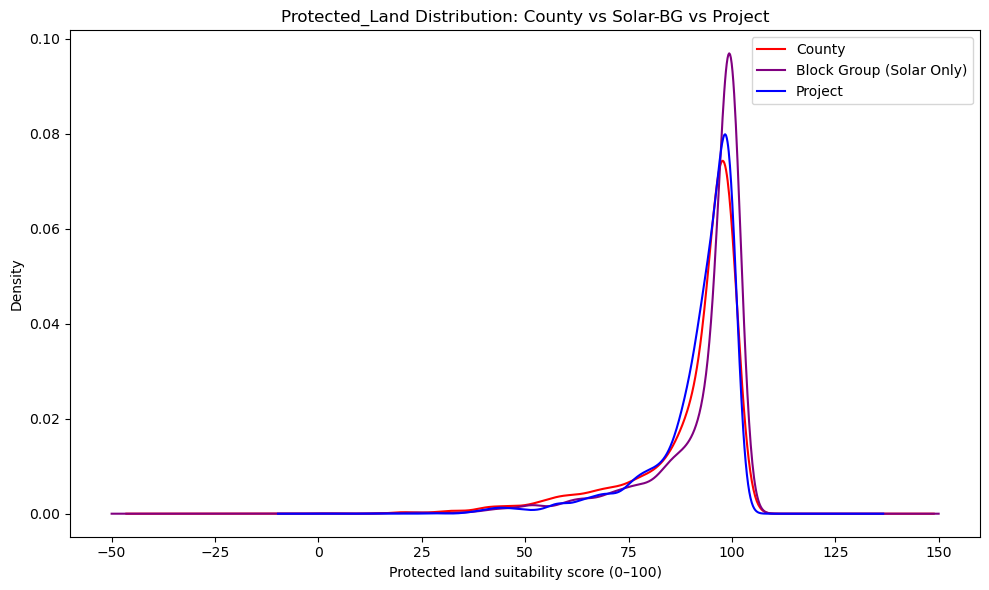

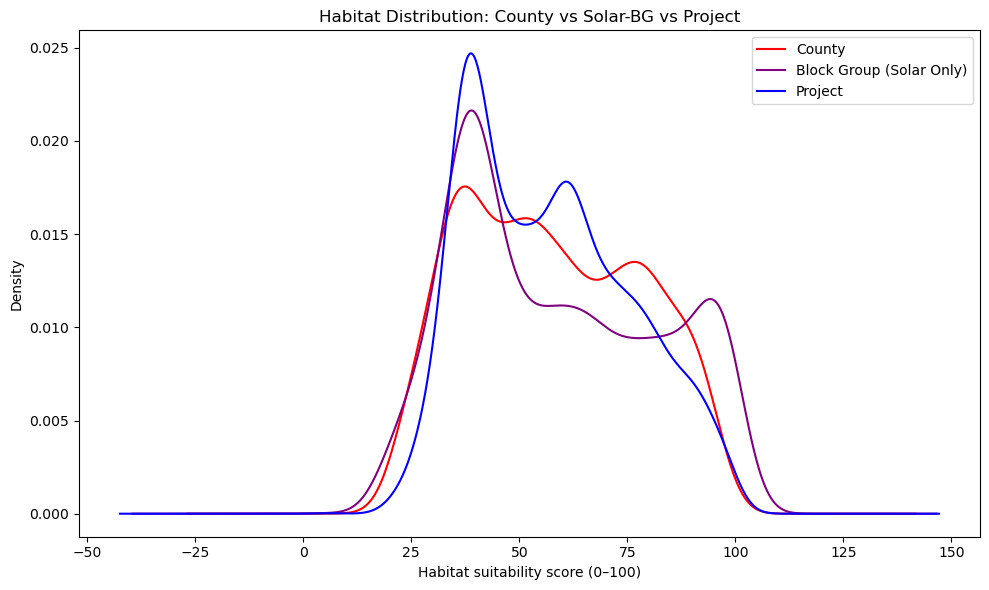

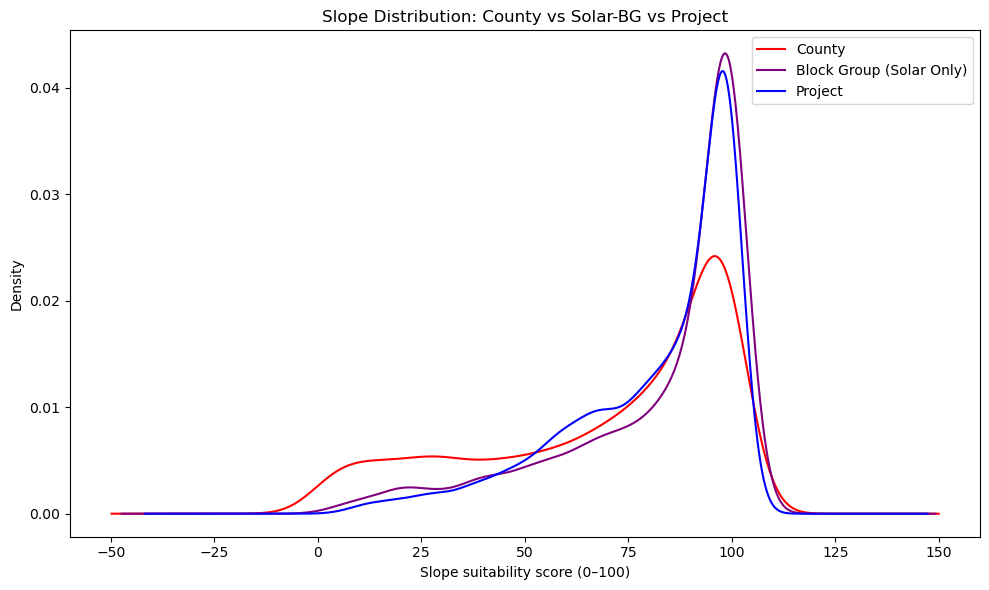

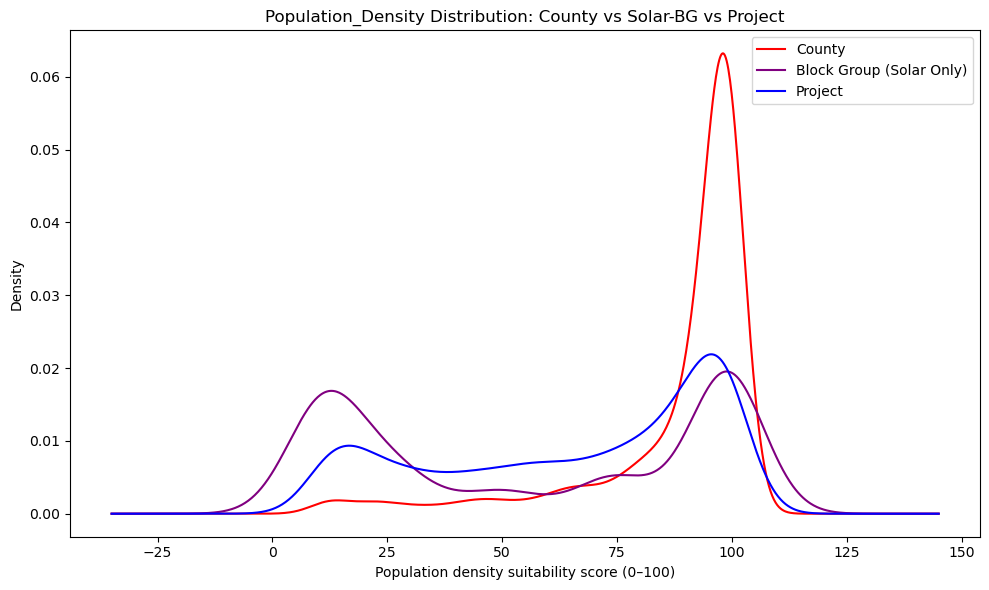

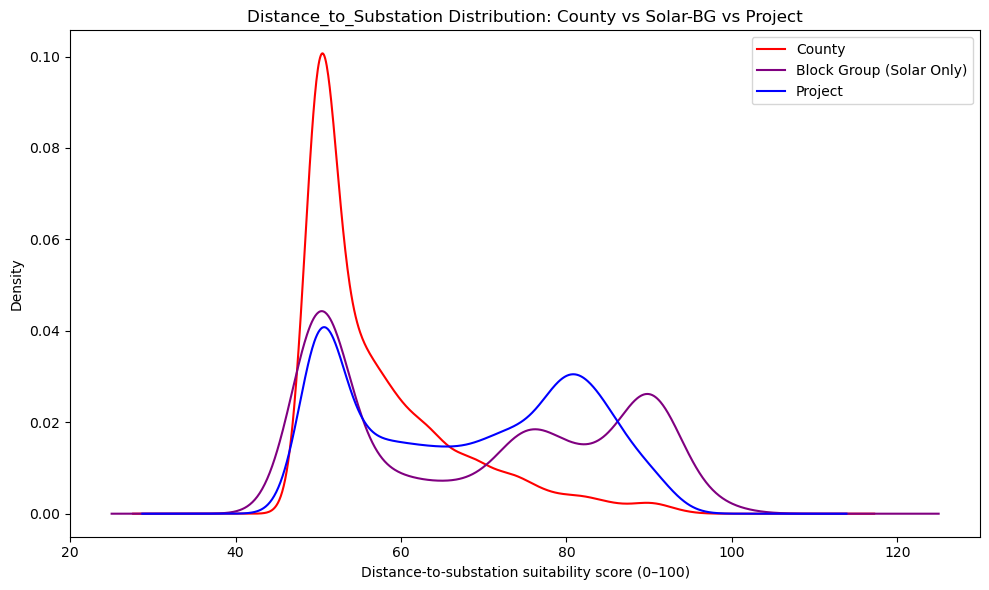

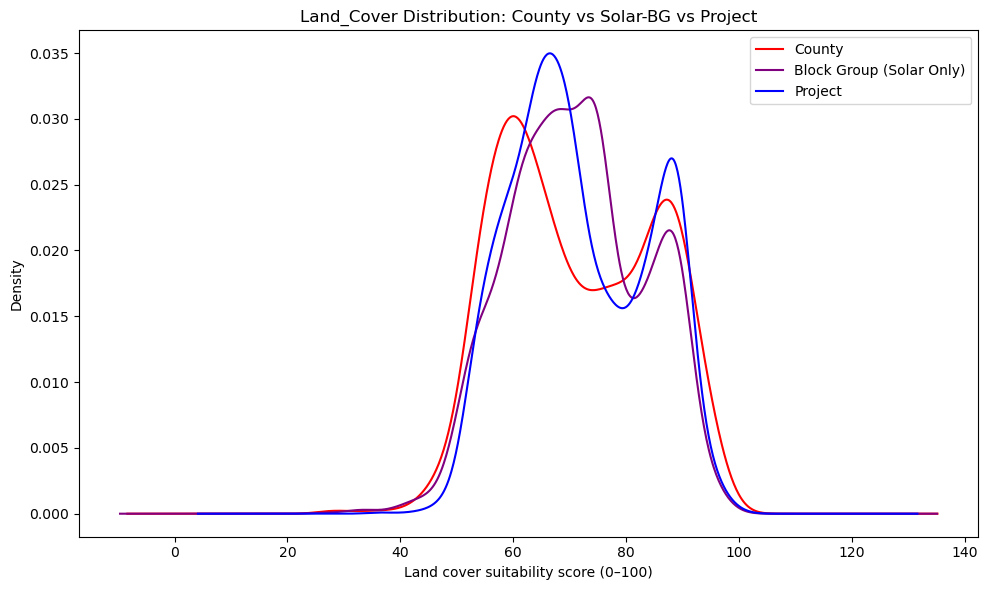

In [52]:
# Cleaner alternative view
for factor in tech_factors:
    c = safe_numeric(suitability_county, factor)
    b_sol = safe_numeric(suitability_bg_solar, factor)
    p = safe_numeric(project_suitability, factor)

    fig, ax = plt.subplots(figsize=(10, 6))

    if c is not None:
        c.plot(kind="kde", ax=ax, color=COLORS["County"], label="County")
    if b_sol is not None:
        b_sol.plot(kind="kde", ax=ax, color=COLORS["Block Group (Solar Only)"], label="Block Group (Solar Only)")
    if p is not None:
        p.plot(kind="kde", ax=ax, color=COLORS["Project"], label="Project")

    ax.set_title(f"{factor} Distribution: County vs Solar-BG vs Project")
    ax.set_xlabel(tech_xlabels.get(factor, f"{factor} suitability score"))
    ax.set_ylabel("Density")

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend()

    plt.tight_layout()
    plt.show()

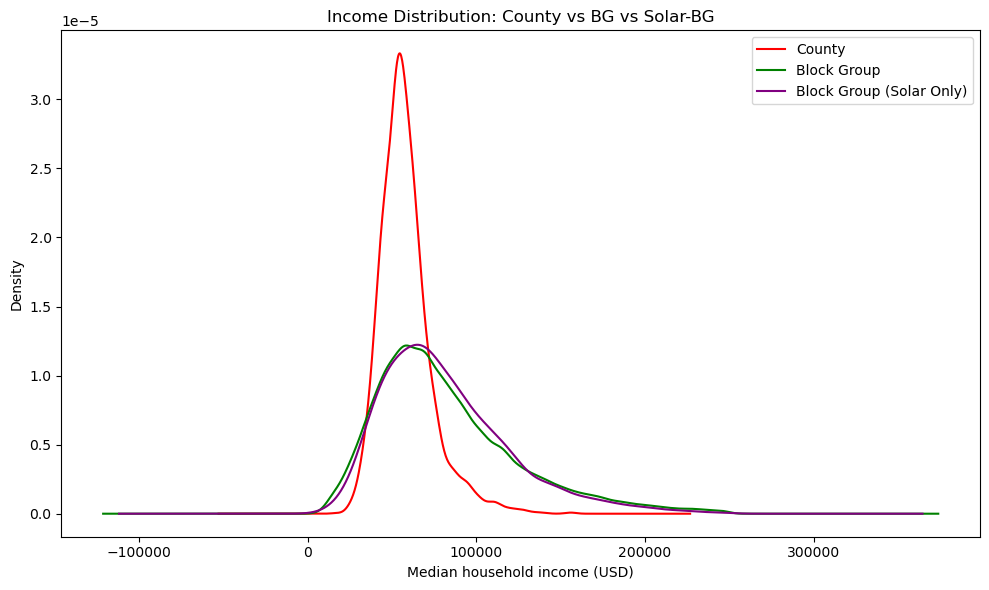

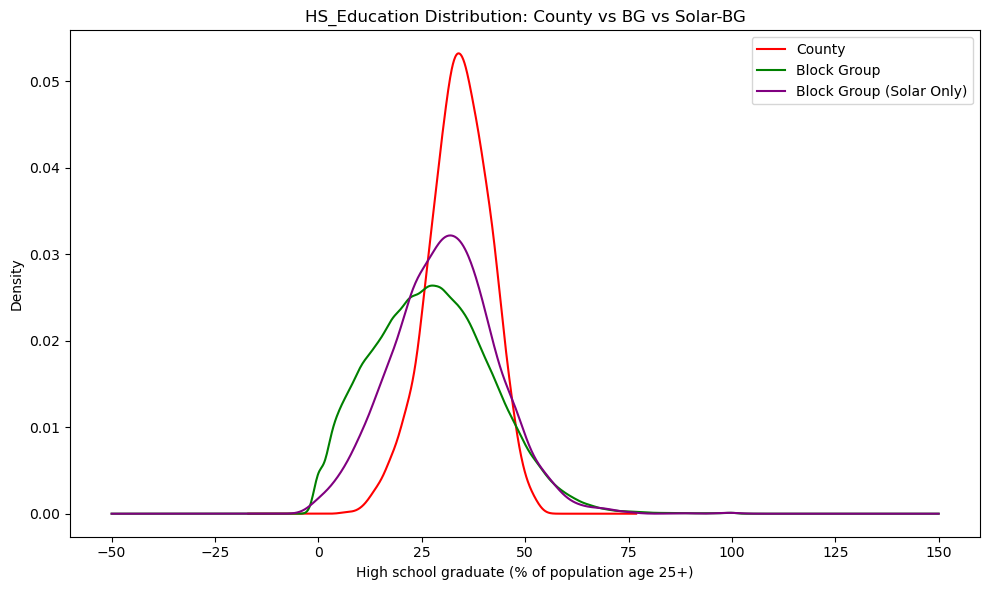

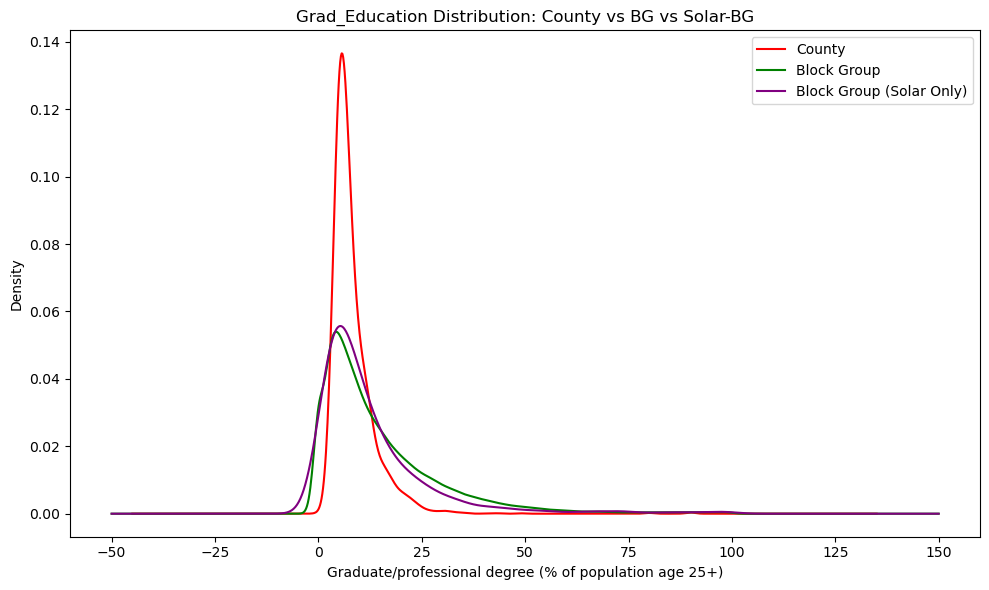

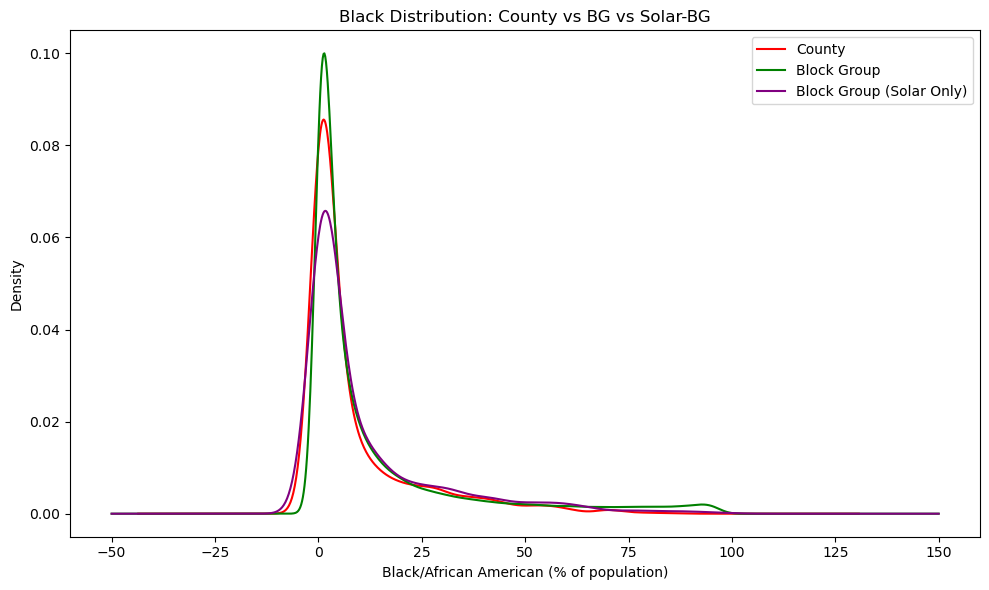

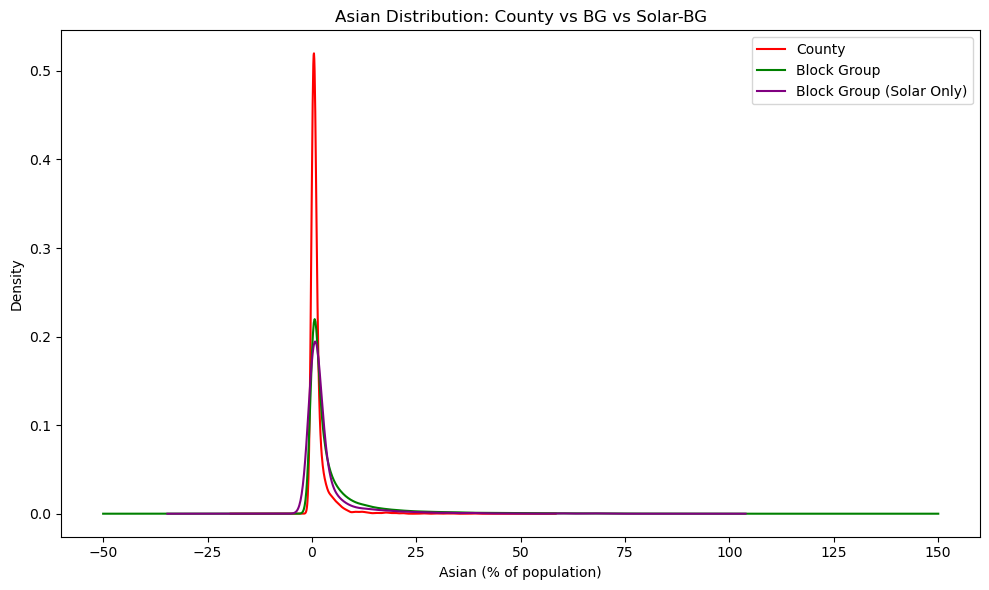

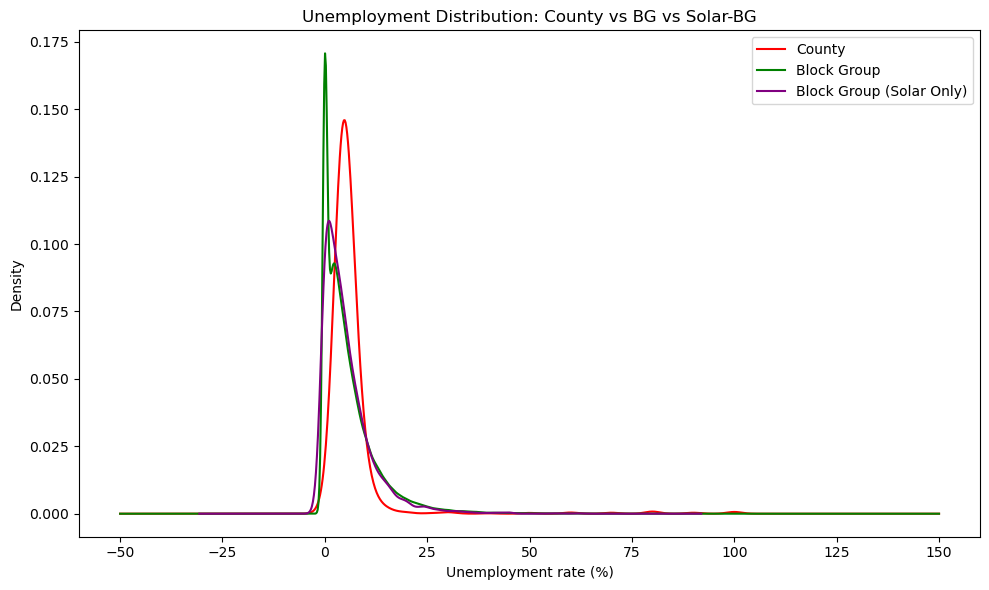

In [53]:
social_factors = ["Income", "HS_Education", "Grad_Education", "Black", "Asian", "Unemployment"]

social_xlabels = {
    "Income": "Median household income (USD)",
    "HS_Education": "High school graduate (% of population age 25+)",
    "Grad_Education": "Graduate/professional degree (% of population age 25+)",
    "Black": "Black/African American (% of population)",
    "Asian": "Asian (% of population)",
    "Unemployment": "Unemployment rate (%)",
}

for factor in social_factors:
    c = safe_numeric(cty_social_small, factor)
    b_all = safe_numeric(bg_social_all, factor)
    b_sol = safe_numeric(bg_social_solar, factor)

    fig, ax = plt.subplots(figsize=(10, 6))

    if c is not None:
        c.plot(kind="kde", ax=ax, color=COLORS["County"], label="County")
    if b_all is not None:
        b_all.plot(kind="kde", ax=ax, color=COLORS["Block Group"], label="Block Group")
    if b_sol is not None:
        b_sol.plot(kind="kde", ax=ax, color=COLORS["Block Group (Solar Only)"], label="Block Group (Solar Only)")

    ax.set_title(f"{factor} Distribution: County vs BG vs Solar-BG")
    ax.set_xlabel(social_xlabels[factor])
    ax.set_ylabel("Density")

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend()

    plt.tight_layout()
    plt.show()